### Что необходимо сделать: реализовать один из алгоритмов машинного обучения, являющегося композицией алгоритмов.
Москаленко Андрей

### Вариант 21

In [1]:
import re
import numpy as np
import cupy as cp
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics

In [2]:
import tqdm.notebook
from joblib import Parallel, delayed

In [3]:
lines = []
with open('./reg.train.txt', 'r') as f:
    lines = f.readlines()
lines = list(map(lambda x: re.split(':| ', x.strip()), lines))
X_train = np.full((7200, 245), 0.0)
y_train = np.zeros((7200))
for i in range(len(lines)):
    y_train[i] = float(lines[i][0])
    for j in range(1, len(lines[i]), 2):
        X_train[i, int(lines[i][j]) - 1] = float(lines[i][j + 1])
X_train = np.nan_to_num(X_train)

In [4]:
lines = []
with open('./reg.test.txt', 'r') as f:
    lines = f.readlines()
lines = list(map(lambda x: re.split(':| ', x.strip()), lines))
X_test = np.full((10050, 245), 0.0)
y_test = np.zeros((10050))
for i in range(len(lines)):
    y_test[i] = float(lines[i][0])
    for j in range(1, len(lines[i]), 2):
        X_test[i, int(lines[i][j]) - 1] = float(lines[i][j + 1])
X_test = np.nan_to_num(X_test)

In [5]:
path_index = -1

class Node:
    def __init__(self, x, y, idxs, min_leaf=5, depth=4, max_features=999):
        global path_index
        path_index += 1
        self.path_index = path_index
        self.depth=depth
        self.x = x
        self.y = y
        self.idxs = idxs
        self.y_idx = y[self.idxs]
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.max_features = max_features
        self.find_varsplit()

    def find_varsplit(self):
        if self.depth != 0:
            while True:
                random_features = np.random.choice(list(range(self.col_count)), self.max_features)
                splits = Parallel(n_jobs=16)(delayed(self.find_better_split)(c) for c in random_features)
                splits = np.array(splits)
                best_id = np.argsort(splits[:, 0])[0]
                self.score = splits[best_id][0]
                if not self.is_leaf:
                    break
            self.split = splits[best_id][1]
            self.var_idx = int(splits[best_id][2])
            if self.is_leaf:
                return
            x = self.x[self.idxs, self.var_idx]
            lhs = np.nonzero(x <= self.split)[0]
            rhs = np.nonzero(x > self.split)[0]
            self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, self.depth - 1, self.max_features)
            self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, self.depth - 1, self.max_features)

    def find_better_split(self, var_idx):
        x = self.x[self.idxs, var_idx]
        best_score = 99999999999999
        best_split = 0
        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: 
                continue
            curr_score = self.find_score(lhs, rhs)
            if curr_score < best_score:
                best_score = curr_score
                best_split = x[r]
        return [best_score, best_split, var_idx]

    def find_score(self, lhs, rhs):
        return ((self.y_idx[lhs] - self.y_idx[lhs].mean()) ** 2).sum() + \
               ((self.y_idx[rhs] - self.y_idx[rhs].mean()) ** 2).sum()

    @property
    def is_leaf(self): 
        return self.score == float('inf')
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    def predict_row(self, xi):
        if self.is_leaf:
            return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

    def apply(self, x):
        return np.array([self.apply_row(xi) for xi in x])
    def apply_row(self, xi):
        if self.is_leaf:
            return self.path_index
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.apply_row(xi)

In [6]:
class MyDecisionTreeRegressor:
    def __init__(self, min_samples_leaf=5, max_depth=4, max_features=16):
        global path_index
        path_index = -1
        self.min_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features
    def fit(self, X, y):
        self.tree_ = Node(X, y, np.array(np.arange(len(y))), self.min_leaf, self.max_depth, self.max_features)
        self.tree_.node_count = 2 ** (self.max_depth + 1) - 1
        return self

    def apply(self, X):
        return self.tree_.apply(X)
    
    def predict(self, X):
        return self.tree_.predict(X)

In [7]:
my_model = MyDecisionTreeRegressor(max_depth=4, min_samples_leaf=5, max_features=16)

In [8]:
my_model.fit(X_train, y_train)
y_pred = my_model.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.7847847214969169

### Hand-written gradient boosting

In [9]:
from sklearn.tree import DecisionTreeRegressor

class GradBoost():
    def __init__(self, n_trees=1, lr=0.1, min_samples_leaf=5, max_depth=4, max_features=16):
        self.n_trees = n_trees
        self.lr = lr
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self,X,y):
        y = y.reshape(-1, 1)
        self.X=X
        self.y=y
        self.boosted_models = []

        self.mean = np.mean(y)
        ensemble_pred = np.ones(len(y)) * self.mean
        
        for i in range(self.n_trees):
            model = MyDecisionTreeRegressor(
                min_samples_leaf=self.min_samples_leaf, max_depth=self.max_depth, max_features=self.max_features)
            residuals = np.sum([y, -ensemble_pred.reshape(-1,1)], axis=0)
            model.fit(X, residuals)
            self.boosted_models.append(model)
            ensemble_pred = np.sum([ensemble_pred, self.lr * model.predict(X)], axis=0)

    def predict(self, X_test):
        pred = np.ones(X_test.shape[0]) * self.mean
        for model in self.boosted_models:
            pred = pred + self.lr * model.predict(X_test)
        return pred.reshape(-1, 1)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

loss = []
my_loss = []
n_trees = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
max_features = int(np.sqrt(X_train.shape[1]))

loss_train = []
my_loss_train = []


for n_estimators in tqdm.notebook.tqdm(n_trees):
    my_model = GradBoost(n_estimators, lr=0.1, max_depth=4, min_samples_leaf=5, max_features=max_features)
    my_model.fit(X_train, y_train)
    y_pred = my_model.predict(X_test)
    my_loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    y_pred = my_model.predict(X_train)
    my_loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, learning_rate=0.1, max_depth=4, criterion='mse', min_samples_leaf=5, max_features=max_features)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    y_pred = model.predict(X_train)
    loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))

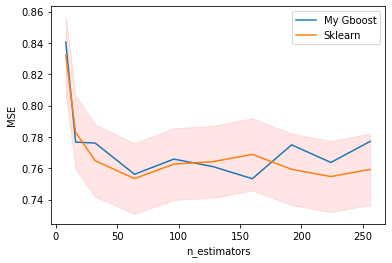

In [11]:
### Test
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees[:len(my_loss)], my_loss, label='My Gboost')
ax.plot(n_trees[:len(loss)], loss, label='Sklearn')

ax.fill_between(n_trees[:len(loss)], (loss-ci), (loss+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

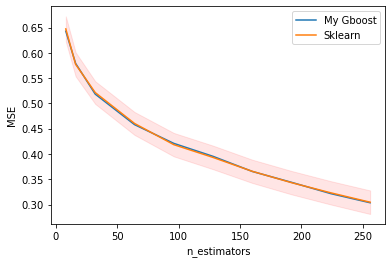

In [12]:
### Train
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees[:len(my_loss_train)], my_loss_train, label='My Gboost')
ax.plot(n_trees[:len(loss_train)], loss_train, label='Sklearn')

ax.fill_between(n_trees[:len(loss_train)], (loss_train-ci), (loss_train+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

### LinReg over trees

In [13]:
import sklearn.utils
def batch_generator(X, y, shuffle=True, batch_size=1):
    if shuffle:
        X, y = sklearn.utils.shuffle(X, y)
    else:
        X, y = X.copy(), y.copy()
    for i in range((len(X) - batch_size) // batch_size):
        X_batch = X[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        yield (X_batch, y_batch)

In [14]:
### Regressor from 1st semestr
### https://github.com/a-mos/ML19/blob/master/hw2/moskalenko_hw2.ipynb

from sklearn.base import BaseEstimator, RegressorMixin

class MySGDRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, batch_generator, C=100,
                 alpha=0.01, max_epoch=10):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  

    def calc_loss(self, X_batch, y_batch):
        loss = np.mean((y_batch - self.__predict(X_batch)) ** 2) +\
                np.dot(self.weights, self.weights) / self.C
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        grad = np.zeros(X_batch.shape[1])
        for i in range(self.batch_size):
            grad += (self.__predict(X_batch[i]) - y_batch[i]) * X_batch[i]
        loss_grad = 2 * grad / self.batch_size + 2 * self.weights / self.C

        return loss_grad

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y, batch_size=10):
        X = np.hstack((X, np.ones((X.shape[0], 1)))).astype(np.longdouble)
        np.random.seed(1337)
        self.weights = np.random.normal(size = X.shape[1]).astype(np.longdouble)
        self.batch_size = batch_size
        for n in tqdm.notebook.tqdm(range(self.max_epoch)):
            new_epoch_generator = self.batch_generator(X, y, batch_size=batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]            
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
        return self

    def __predict(self, X):
        y_hat = X @ self.weights
        return y_hat

    def predict(self, X):
        X = np.hstack((X, np.ones((X.shape[0], 1)))).astype(np.longdouble)
        y_hat = X @ self.weights
        return y_hat

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=256, learning_rate=0.1, max_depth=4, criterion='mse', min_samples_leaf=5, max_features=16)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sklearn.metrics.mean_squared_error(y_pred, y_test)

0.7597578930945365

In [16]:
my_model = GradBoost(256, 0.1, max_depth=4, min_samples_leaf=5, max_features=16)
my_model.fit(X_train, y_train)
y_pred = my_model.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, y_pred)

0.7646725933324832

In [17]:
path_index = -1
def gen_features(X, models_list):
    To_regression = []
    
    Vec_preds = [model.predict(X) for model in models_list]
    
    for i, Sample in enumerate(X):
        Sample = Sample[np.newaxis, ...]
        vec_total = []
        for model_id in range(len(models_list)):
            vec = [0] * models_list[model_id].tree_.node_count
            num = models_list[model_id].apply(Sample)[0]
            #vec[num] = models_list[model_id].predict(Sample)[0]
            vec[num] = Vec_preds[model_id][i]
            vec_total += vec
        To_regression.append(vec_total)

    return np.array(To_regression)

In [18]:
my_reg_features_train = gen_features(X_train, my_model.boosted_models)
idx = np.argwhere(np.all(my_reg_features_train[..., :] == 0.0, axis=0))
my_reg_features_train = np.delete(my_reg_features_train, idx, axis=1)
my_reg_features_test = gen_features(X_test, my_model.boosted_models)
my_reg_features_test = np.delete(my_reg_features_test, idx, axis=1)

In [19]:
reg_features_train = gen_features(X_train, [x[0] for x in model.estimators_])
idx = np.argwhere(np.all(reg_features_train[..., :] == 0.0, axis=0))
reg_features_train = np.delete(reg_features_train, idx, axis=1)
reg_features_test = gen_features(X_test, [x[0] for x in model.estimators_])
reg_features_test = np.delete(reg_features_test, idx, axis=1)

In [38]:
lin_reg = sklearn.linear_model.SGDRegressor(learning_rate = 'constant', alpha = 0.01, eta0 = 0.01, shuffle=True)
for epoch in tqdm.tqdm_notebook(range(100)):
    gen = batch_generator(reg_features_train, y_train, batch_size=10)
    for X_batch, y_batch in gen:
        lin_reg.partial_fit(X_batch, y_batch)
lin_reg = lin_reg.predict(reg_features_test)
sklearn.metrics.mean_squared_error(y_test, lin_reg)

C:\Users\andry\Anaconda3\envs\subjectify\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0.7597998370696183

In [39]:
### Custom SGD
model_lin = MySGDRegressor(batch_generator, alpha=0.01, max_epoch=100, C=100)
my_y_pred = model_lin.fit(my_reg_features_train, y_train, batch_size=10).predict(my_reg_features_test)
sklearn.metrics.mean_squared_error(y_test, my_y_pred)

0.7622772100614364

### Last comparison (whole ensemble)

In [40]:
import tqdm
max_features = int(np.sqrt(X_train.shape[1]))

loss = []
my_loss = []

loss_train = []
my_loss_train = []

n_trees = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]

for n_estimators in tqdm.notebook.tqdm(n_trees):
    global path_index
    path_index = -1
    my_model = GradBoost(n_estimators, lr=0.1, max_depth=4, min_samples_leaf=5, max_features=max_features)
    my_model.fit(X_train, y_train)
    
    my_reg_features_train = gen_features(X_train, my_model.boosted_models)
    idx = np.argwhere(np.all(my_reg_features_train[..., :] == 0.0, axis=0))
    my_reg_features_train = np.delete(my_reg_features_train, idx, axis=1)
    my_reg_features_test = gen_features(X_test, my_model.boosted_models)
    my_reg_features_test = np.delete(my_reg_features_test, idx, axis=1)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, learning_rate=0.1, max_depth=4, criterion='mse', min_samples_leaf=5, max_features=max_features)
    model.fit(X_train, y_train)
    
    reg_features_train = gen_features(X_train, [x[0] for x in model.estimators_])
    idx = np.argwhere(np.all(reg_features_train[..., :] == 0.0, axis=0))
    reg_features_train = np.delete(reg_features_train, idx, axis=1)
    reg_features_test = gen_features(X_test, [x[0] for x in model.estimators_])
    reg_features_test = np.delete(reg_features_test, idx, axis=1)
    
    ### Sklearn mini-batch linear model
    lin_reg = sklearn.linear_model.SGDRegressor(learning_rate = 'constant', alpha = 0.01, eta0 = 0.01, shuffle=True)
    for epoch in range(100):
        gen = batch_generator(reg_features_train, y_train, batch_size=10)
        for X_batch, y_batch in gen:
            lin_reg.partial_fit(X_batch, y_batch)
    
    y_pred = lin_reg.predict(reg_features_test)
    loss.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    y_pred = lin_reg.predict(reg_features_train)
    loss_train.append(sklearn.metrics.mean_squared_error(y_train, y_pred))
    
    ### Custom mini-batch linear model
    model_lin = MySGDRegressor(
        batch_generator, alpha=0.01, max_epoch=100, C=100).fit(my_reg_features_train, y_train, batch_size=10)
    
    my_y_pred = model_lin.predict(my_reg_features_test)
    my_loss.append(sklearn.metrics.mean_squared_error(y_test, my_y_pred))
    
    my_y_pred = model_lin.predict(my_reg_features_train)
    my_loss_train.append(sklearn.metrics.mean_squared_error(y_train, my_y_pred))

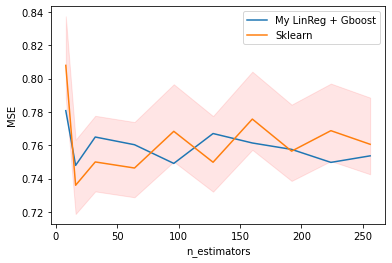

In [41]:
# Test
ci = np.multiply(loss, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees, my_loss, label='My LinReg + Gboost')
ax.plot(n_trees, loss, label='Sklearn')

ax.fill_between(n_trees, (loss-ci), (loss+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

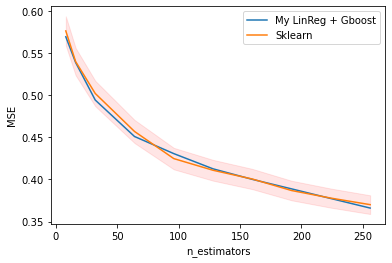

In [42]:
# Train
ci = np.multiply(loss_train, 0.03)

fig, ax = plt.subplots()
ax.plot(n_trees, my_loss_train, label='My LinReg + Gboost')
ax.plot(n_trees, loss_train, label='Sklearn')

ax.fill_between(n_trees, (loss_train-ci), (loss_train+ci), color='r', alpha=.1)
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend()

С мини-батчами и регуляризацией overfit-а нет, но прирост над бустингом либо очень незначительный (в втором знаке), либо наоборот незначительное ухудшение. Если убрать регуляризацию, то сильно переобучается даже на мини-батчах.